In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp

from commstools import Signal

# generate chirp
fs = 1e7
duration = 1e-4
t = np.arange(int(fs * duration)) / fs
f0 = 600e3
f1 = 1200e3
samples = chirp(t, f0, duration, f1, method="linear")

# # add noise
# noise = np.random.randn(len(samples))
# samples += 1 * noise


sig = Signal(samples=samples, sampling_rate=fs)


(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='Frequency', ylabel='Power Spectral Density (dB/Hz)'>)

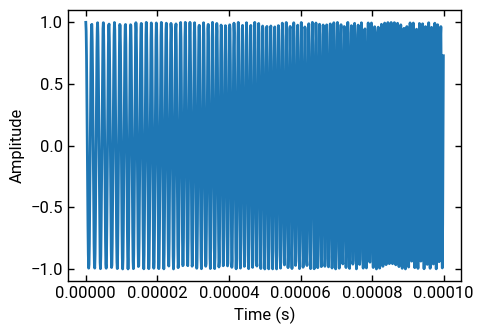

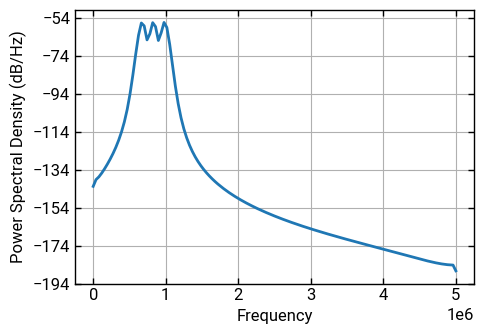

In [3]:
# fig, axs = plt.subplots(2, 1)

sig.plot_signal()
sig.plot_psd()


In [ ]:
import numpy as np

from commstools import Signal, jit, set_backend


# 1. Define a processing function (JIT-enabled)
@jit
def apply_gain(signal: Signal, gain: float) -> Signal:
    # Operations are backend-agnostic
    # .like() returns a new Signal with same metadata but new samples
    return signal.update(signal.samples * gain)


# 2. Create a Signal (defaults to NumPy)
set_backend("numpy")
sig = Signal(samples=np.exp(1j * 2 * np.pi * np.arange(1000) * 0.01), sampling_rate=1e6)

# 3. Process on CPU (NumPy)
out_numpy = apply_gain(sig, gain=2.0)
print(f"NumPy Output: {type(out_numpy.samples)}")

# 4. Process on GPU (JAX) - Seamless Switch
try:
    set_backend("jax")

    # Apply same function (now runs on JAX and is JIT compiled!)
    out_jax = apply_gain(sig, gain=2.0)

    print(f"JAX Output:   {type(out_jax.samples)}")

    # Compute Spectrum (accelerated)
    freqs, psd = out_jax.spectrum()
except ImportError:
    print("JAX not installed, skipping GPU demo.")


NumPy Output: <class 'numpy.ndarray'>


W1125 16:08:43.171441  141191 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1125 16:08:43.173990  141112 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


JAX Output:   <class 'jaxlib._jax.ArrayImpl'>


In [ ]:
set_backend("numpy")


In [3]:
type(sig.samples)


numpy.ndarray

In [ ]:
set_backend("jax")


In [ ]:
import numpy as np
from commstools.dsp.functions import spectrum

from commstools.core.backend import get_backend, set_backend
from commstools.core.signal import Signal


def test_backend_switch():
    print("Testing Backend Switching...")

    # Test Numpy Backend
    print("\n--- Setting Backend to Numpy ---")
    set_backend("numpy")
    data = np.array([1 + 1j, 2 + 2j, 3 + 3j, 4 + 4j])
    sig_np = Signal(samples=data, sampling_rate=100)

    print(f"Current Backend: {get_backend().name}")
    print(f"Signal Backend: {sig_np.backend.name}")
    print(f"Samples Type: {type(sig_np.samples)}")

    assert sig_np.backend.name == "numpy"
    assert isinstance(sig_np.samples, np.ndarray)

    # Test Spectrum Function
    freqs, psd = spectrum(sig_np)
    print(f"Spectrum Output Type: {type(psd)}")
    assert isinstance(psd, np.ndarray)

    # Test JAX Backend if available
    try:
        import jax
        import jax.numpy as jnp

        print("\n--- Setting Backend to JAX ---")
        set_backend("jax")

        # Create signal with numpy data, should auto-convert
        sig_jax = Signal(samples=data, sampling_rate=100)

        print(f"Current Backend: {get_backend().name}")
        print(f"Signal Backend: {sig_jax.backend.name}")
        print(f"Samples Type: {type(sig_jax.samples)}")

        assert sig_jax.backend.name == "jax"
        assert not isinstance(sig_jax.samples, np.ndarray)  # Should be JAX array

        # Test Spectrum Function on JAX signal
        freqs_jax, psd_jax = spectrum(sig_jax)
        print(f"Spectrum Output Type: {type(psd_jax)}")
        assert not isinstance(psd_jax, np.ndarray)  # Should be JAX array

    except ImportError:
        print("\nJAX not installed, skipping JAX tests.")
    # except Exception as e:
    #     print(f"\nJAX Test Failed: {e}")


test_backend_switch()


Testing Backend Switching...

--- Setting Backend to Numpy ---
Current Backend: numpy
Signal Backend: numpy
Samples Type: <class 'numpy.ndarray'>
Spectrum Output Type: <class 'numpy.ndarray'>

--- Setting Backend to JAX ---


W1125 16:23:12.911548  144538 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1125 16:23:12.914018  144168 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Current Backend: jax
Signal Backend: jax
Samples Type: <class 'jaxlib._jax.ArrayImpl'>
Spectrum Output Type: <class 'jaxlib._jax.ArrayImpl'>


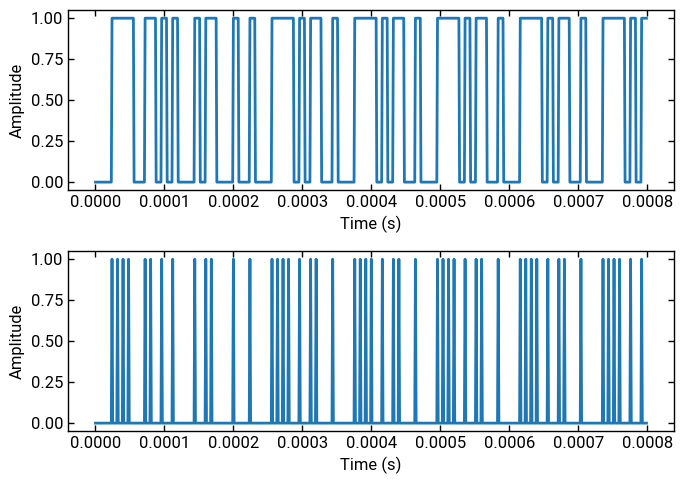

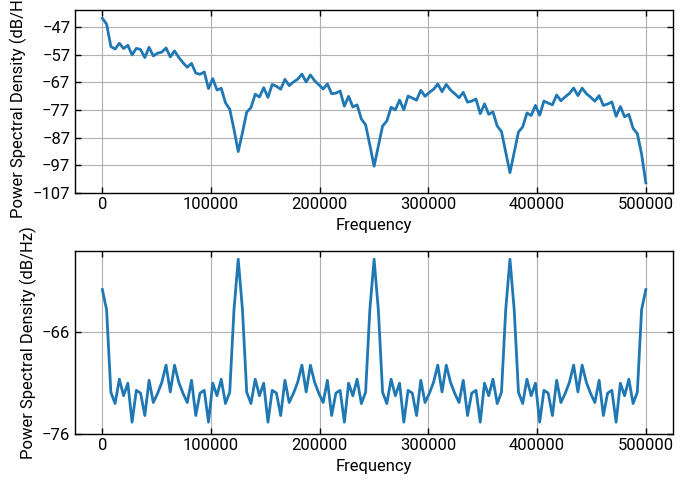

In [85]:
import matplotlib.pyplot as plt
import numpy as np

from commstools import SystemConfig, set_config
from commstools.dsp.sequences import prbs
from commstools.dsp.waveforms import ook

config = SystemConfig(sampling_rate=1e6, samples_per_symbol=8)
set_config(config)

bits = prbs(100, seed=0x12345678, order=31)
sig_rect = ook(bits, pulse_type="rect")
sig_imp = ook(bits, pulse_type="impulse")

fig, axs = plt.subplots(2, 1, figsize=(7, 5))
_, _ = sig_rect.plot_signal(ax=axs[0])
_, _ = sig_imp.plot_signal(ax=axs[1])

fig, axs = plt.subplots(2, 1, figsize=(7, 5))
_, _ = sig_rect.plot_psd(ax=axs[0])
_, _ = sig_imp.plot_psd(ax=axs[1])


125000.0